In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

import statsmodels.api as sm

from pyspark.sql.functions import substring, length, col, expr
import pyspark.sql.functions as func

In [2]:
spark = SparkSession\
.builder\
.appName("Python Spark app")\
.getOrCreate()

#Check we have a spark context: Should show the spark version and app name
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark app>

In [3]:
from datetime import datetime as dt 
start_time = dt.now() 

In [4]:
url_crime = "https://chisom.blob.core.windows.net/chisom/all_crimes21_hdr.txt.gz"

In [5]:
spark.sparkContext.addFile(url_crime)

In [6]:
df_crime = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)

In [7]:
url_lsoa = "http://unn-izje1.newnumyspace.co.uk/LSOA_pop_v2.csv"

In [8]:
spark.sparkContext.addFile(url_lsoa)

In [9]:
df_lsoa = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

In [10]:
myschema = StructType(
    [
        StructField('Crime_ID', StringType(),False),
        StructField('Month', StringType(),False),
        StructField('Reported_by', StringType(),False),
        StructField('Falls', StringType(),False),
        StructField('Long', DoubleType(),False),
        StructField('Lat', DoubleType(),False),
        StructField('Location', StringType(),False),
        StructField('LSOA', StringType(),False),
        StructField('LSOA_Name', StringType(),False),
        StructField('Crime_Type', StringType(),False),
        StructField('Last_Outcome', StringType(),False),
        StructField('Context', StringType(),False)
    ]
)

In [11]:
myschema_lsoa = StructType(
    [
        StructField('Date', StringType(),False),
        StructField('Geography', StringType(),False),
        StructField('Geography_ID', StringType(),False),
        StructField('Rur_Urb', StringType(),False),
        StructField('Res', IntegerType(),False),
        StructField('Male_Res', IntegerType(),False),
        StructField('Female_Res', IntegerType(),False),
        StructField('HouseHold', IntegerType(),False),
        StructField('Commune', StringType(),False),
        StructField('Sch_fll4', StringType(),False),
        StructField('Area', IntegerType(),False),
        StructField('Density', StringType(),False)
    ]
)

In [12]:
df_crime = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema= myschema)

In [13]:
df_lsoa = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, schema= myschema_lsoa)

In [14]:
df_crime =(df_crime
              .select('*')
              .where((df_crime.Long.between('-7.64133','1.75159')) & (df_crime.Lat.between('50.10319','60.15456')))
)

In [15]:
#df_lsoa = df_lsoa.withColumn("Region", expr("substring(Geography, 1, length(Geography)-5)"))

In [16]:
pop_df = df_lsoa.select('Geography', 'Res', 'Geography_ID')

In [17]:
crime_loc_df = (df_crime.alias('df')
         .join(pop_df.alias('ls'),col('df.LSOA') == col('ls.Geography_ID'))
         .select([col('df.Crime_Type'), col('df.Month')] + [col('ls.Res')])
         .where(df_crime.Month.startswith('2011-'))
         .groupBy('Crime_Type')
        )

In [18]:
crime_loc_sum = (crime_loc_df
         .agg(sum('Res').alias('Population'))
        )

In [19]:
crime_loc_count = (crime_loc_df
         .agg(count('Crime_Type').alias('Crime_Count'))
         .orderBy('Crime_Count')
        )

In [20]:
df_crime_loc = crime_loc_count.alias('df').join(crime_loc_sum.alias('ls'), (col('df.Crime_Type') == col('ls.Crime_Type'))).select([col('df.*')] + [col('ls.Population')])

In [21]:
df_crime_loc = df_crime_loc.withColumn('Crime_Rate', func.round(( df_crime_loc['Crime_Count'] * 100000 ) / df_crime_loc['Population'], 2))

In [22]:
df_crime_loc.show(truncate = False)

+---------------------------+-----------+----------+----------+
|Crime_Type                 |Crime_Count|Population|Crime_Rate|
+---------------------------+-----------+----------+----------+
|Drugs                      |68996      |118154186 |58.39     |
|Public disorder and weapons|50235      |86101252  |58.34     |
|Other crime                |1524416    |2595341120|58.74     |
|Robbery                    |74388      |130414102 |57.04     |
|Criminal damage and arson  |198826     |331001732 |60.07     |
|Shoplifting                |101570     |175064912 |58.02     |
|Burglary                   |501586     |840307142 |59.69     |
|Violent crime              |715246     |1217728335|58.74     |
|Other theft                |245960     |426492558 |57.67     |
|Vehicle crime              |407824     |687374325 |59.33     |
|Anti-social behaviour      |2761687    |4640496496|59.51     |
+---------------------------+-----------+----------+----------+



In [23]:
pop_df=crime_loc_df=crime_loc_sum=crime_loc_count=df_crime_loc=[]

In [24]:
date_lw = df_crime.groupBy("Crime_Type").agg({"Month":"min"})
date_lw =date_lw.withColumnRenamed('min(Month)', 'First Reported')

In [25]:
date_up = df_crime.groupBy("Crime_Type").agg({"Month":"max"})
date_up =date_up.withColumnRenamed('max(Month)', 'Last Reported')

In [26]:
crime_loc = date_lw.join(date_up, ["Crime_Type"])

In [27]:
crime_loc.show(truncate = False)

+----------------------------+--------------+-------------+
|Crime_Type                  |First Reported|Last Reported|
+----------------------------+--------------+-------------+
|Bicycle theft               |2013-05       |2021-05      |
|Public order                |2013-05       |2021-05      |
|Drugs                       |2011-09       |2021-05      |
|Public disorder and weapons |2011-09       |2013-04      |
|Other crime                 |2010-12       |2021-05      |
|Robbery                     |2010-12       |2021-05      |
|Criminal damage and arson   |2011-09       |2021-05      |
|Theft from the person       |2013-05       |2021-05      |
|Shoplifting                 |2011-09       |2021-05      |
|Burglary                    |2010-12       |2021-05      |
|Violent crime               |2010-12       |2013-04      |
|Other theft                 |2011-09       |2021-05      |
|Possession of weapons       |2013-05       |2021-05      |
|Violence and sexual offences|2013-05   

In [28]:
crime_loc=date_lw=date_up=[]

In [29]:
df_vc = (df_crime
            .select('Crime_Type', 'Month')
            .where(df_crime.Crime_Type == 'Violence and sexual offences')
            .groupBy('Month')
            .agg(count('Crime_Type').alias('Rate'))
            .orderBy('Month'))

In [30]:
vc_pd = df_vc.toPandas()

In [31]:
df_vc=[]

In [32]:
vc_pd.Month = vc_pd.Month.astype('datetime64[ns]')
vc_pd = vc_pd.set_index(pd.to_datetime(vc_pd.Month))

In [33]:
# create a copy of the dataframe, and add columns for month and year
df_m = vc_pd.copy()
df_m['month'] = [i.month for i in df_m.index]
df_m['year'] = [i.year for i in df_m.index]
# group by month and year, get the average
df_m = df_m.groupby(['month', 'year']).mean().dropna()

In [34]:
df_m = df_m.unstack(level=0)

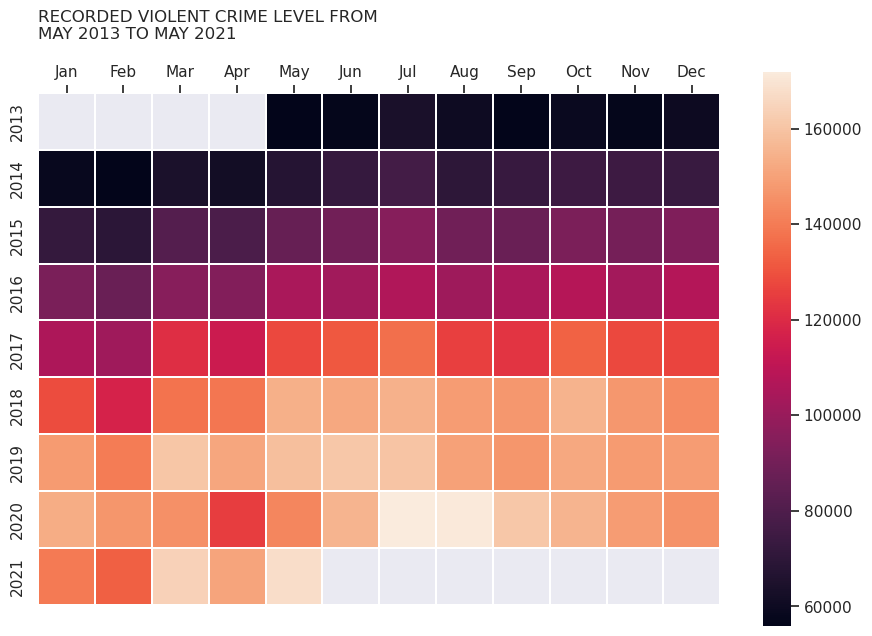

In [35]:
# figure
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(df_m, square=True,
           linewidth=0.3, cbar_kws={"shrink": .8})
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Recorded Violent Crime level from\nMay 2013 to May 2021\n'.upper()
plt.title(title, loc='left')
plt.show()

In [36]:
df_m=[]

In [37]:
plt.figsize=(20, 6)

vc_pd.plot(y='Rate', x='Month',marker='.', linestyle='-', linewidth=1.5,\
         subplots=False,
              label='Violent Crime Rate',
              title='Violent Crime Rate')
plt.ylabel('Violent Crime Frequency')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

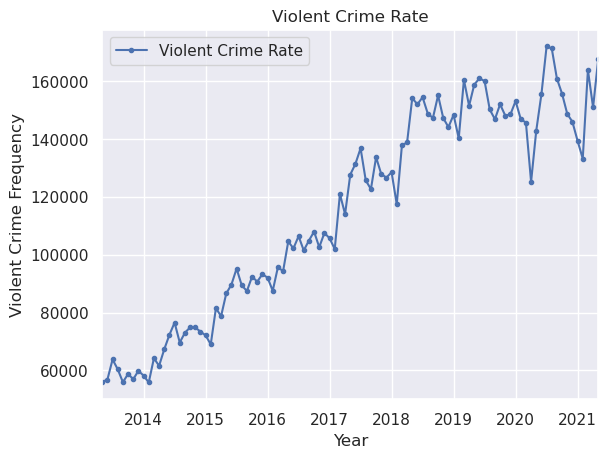

In [38]:
plt.show()

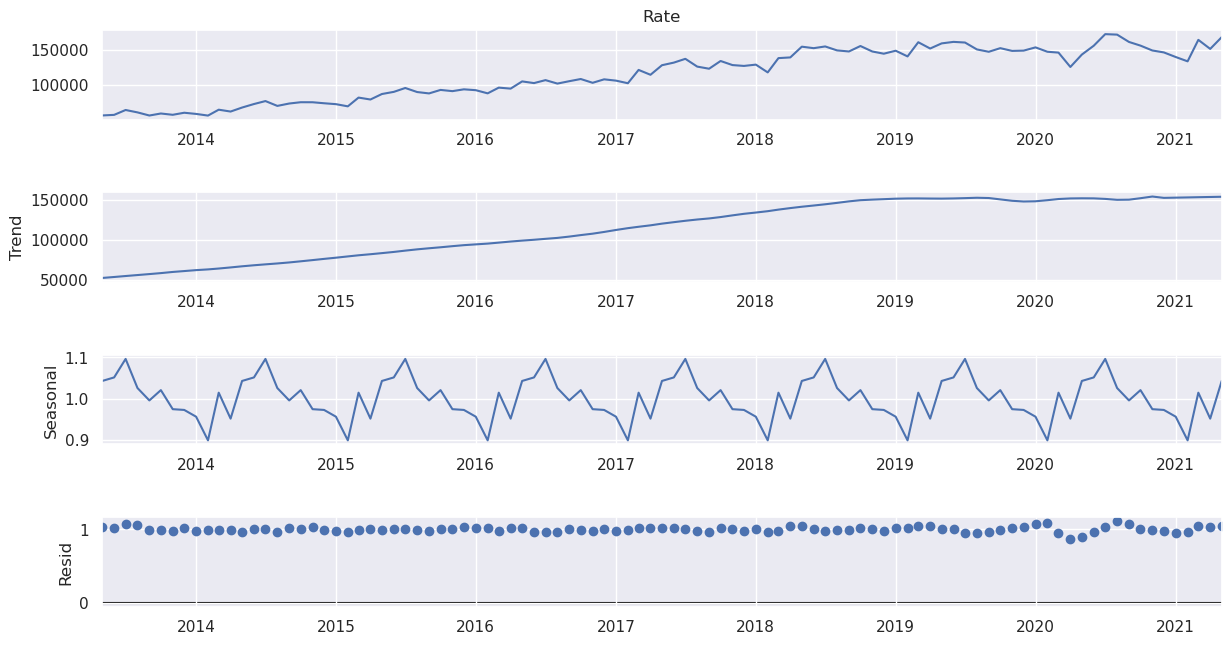

In [39]:
decomposition = sm.tsa.seasonal_decompose(vc_pd['Rate'], model='multiplicative',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [40]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=6).mean() 
    rolstd = pd.Series(timeseries).rolling(window=6).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

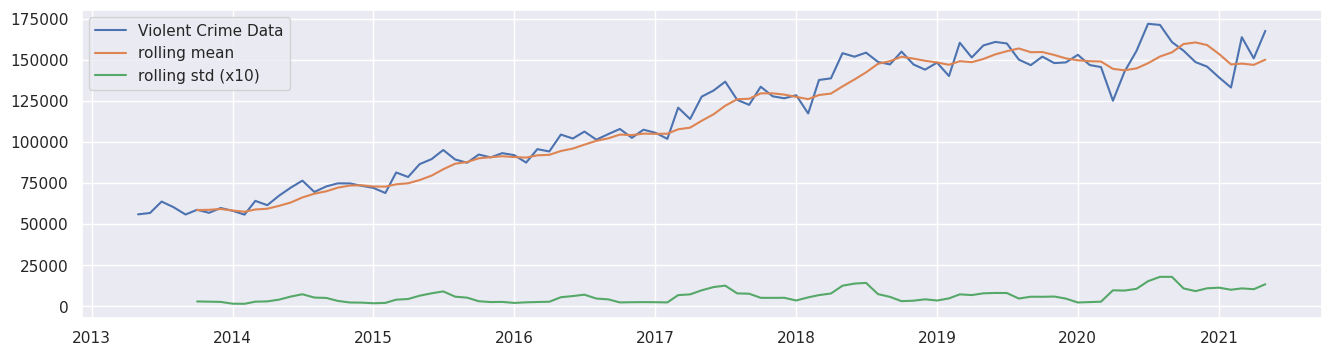

In [41]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(vc_pd['Rate'],'Violent Crime Data')

In [42]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [43]:
ADF_test(vc_pd['Rate'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.782
P-value = 0.390
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is not stationary with 95% confidence
	10%: -2.5854823866213152 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

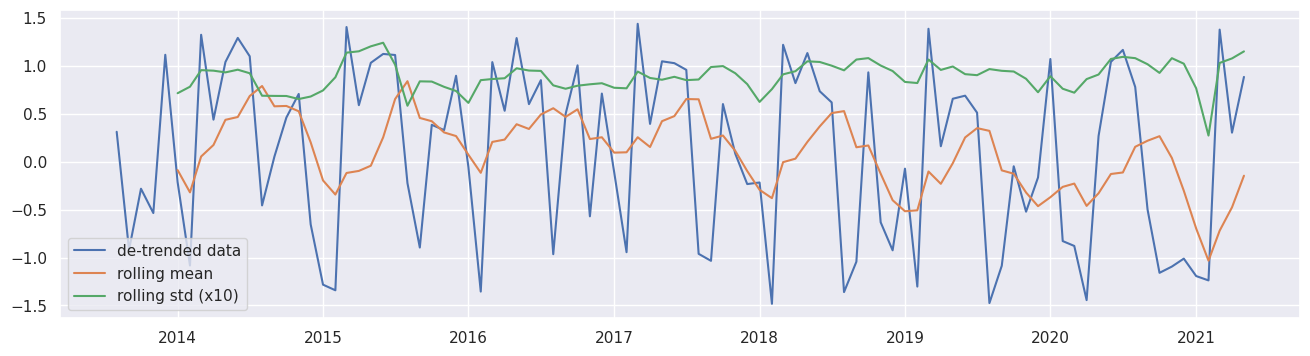

 > Is the de-trended data stationary ?
Test statistic = -1.540
P-value = 0.514
Critical values :
	1%: -3.5137900174243235 - The data is not stationary with 99% confidence
	5%: -2.8979433868293945 - The data is not stationary with 95% confidence
	10%: -2.5861907285474777 - The data is not stationary with 90% confidence


In [44]:
# Detrending
vc = vc_pd['Rate']
dt_vc =  (vc - vc.rolling(window=4).mean())/vc.rolling(window=4).std()

test_stationarity(dt_vc,'de-trended data')
ADF_test(dt_vc,'de-trended data')

<Figure size 640x480 with 0 Axes>

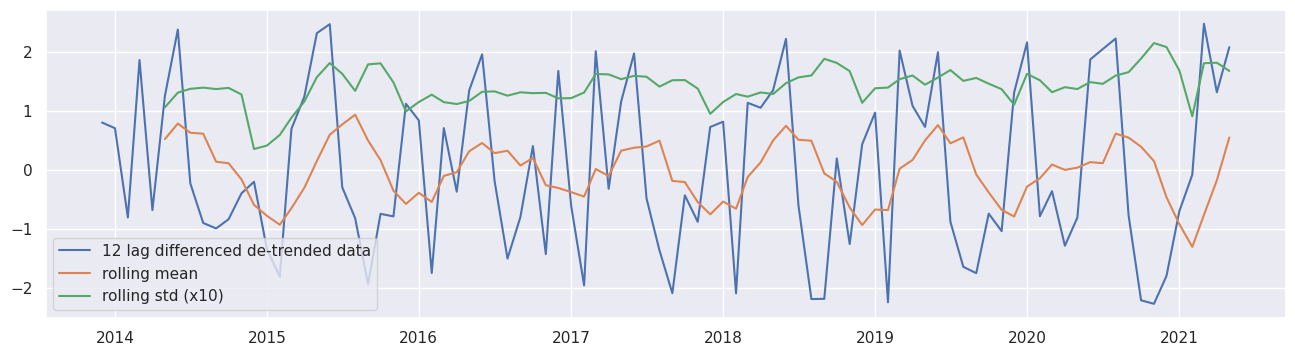

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -6.860
P-value = 0.000
Critical values :
	1%: -3.517113604831504 - The data is  stationary with 99% confidence
	5%: -2.8993754262546574 - The data is  stationary with 95% confidence
	10%: -2.5869547797501644 - The data is  stationary with 90% confidence


In [45]:
# Detrending + Differencing

dtrnd_dffrnc_vc =  dt_vc - dt_vc.shift(4)

test_stationarity(dtrnd_dffrnc_vc,'12 lag differenced de-trended data')

ADF_test(dtrnd_dffrnc_vc,'12 lag differenced de-trended data')

In [46]:
dtrnd_dffrnc_vc

Month
2013-05-01           NaN
2013-06-01           NaN
2013-07-01           NaN
2013-08-01           NaN
2013-09-01           NaN
                 ...    
2021-01-01   -0.69407914
2021-02-01   -0.07905377
2021-03-01    2.47416397
2021-04-01    1.31563889
2021-05-01    2.07917658
Name: Rate, Length: 97, dtype: float64

In [47]:
vc_dtrnded = dtrnd_dffrnc_vc.dropna()

In [48]:
vc_pd=vc=dt_vc= dtrnd_dffrnc_vc=[]

In [49]:
train_ds = vc_dtrnded[:'2020-03'] # dataset to train
test_ds = vc_dtrnded['2020-04': ] # last X months for test  
#predict_date = len(y) - len(y[:'2019-02-01']) # the number of data points for the test set
validate_ds = test_ds

In [50]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 4
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

In [51]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(train_ds,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:262.5811439105467
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:209.22282511647407
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:328.359475288598
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:266.40924996367517
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:244.22009688913298
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:206.13953215202156
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:306.6495360553799
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:252.03174944548397
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:262.47309353668163
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:208.77772932643666
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:327.72786737476827
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:266.38912723303446
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:244.36101525601643
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:205.16529844799732
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:306.83055766091707
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:252.24750404305408
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:299.17924425572204
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:244.83576460474586
ARIMA(0, 1, 0)x(0, 1, 0, 4)4 - A

In [52]:
order = (1, 0, 1) #Using Values from the previous step
seasonal_order = (1, 0, 1, 4)
model = sm.tsa.statespace.SARIMAX(train_ds,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

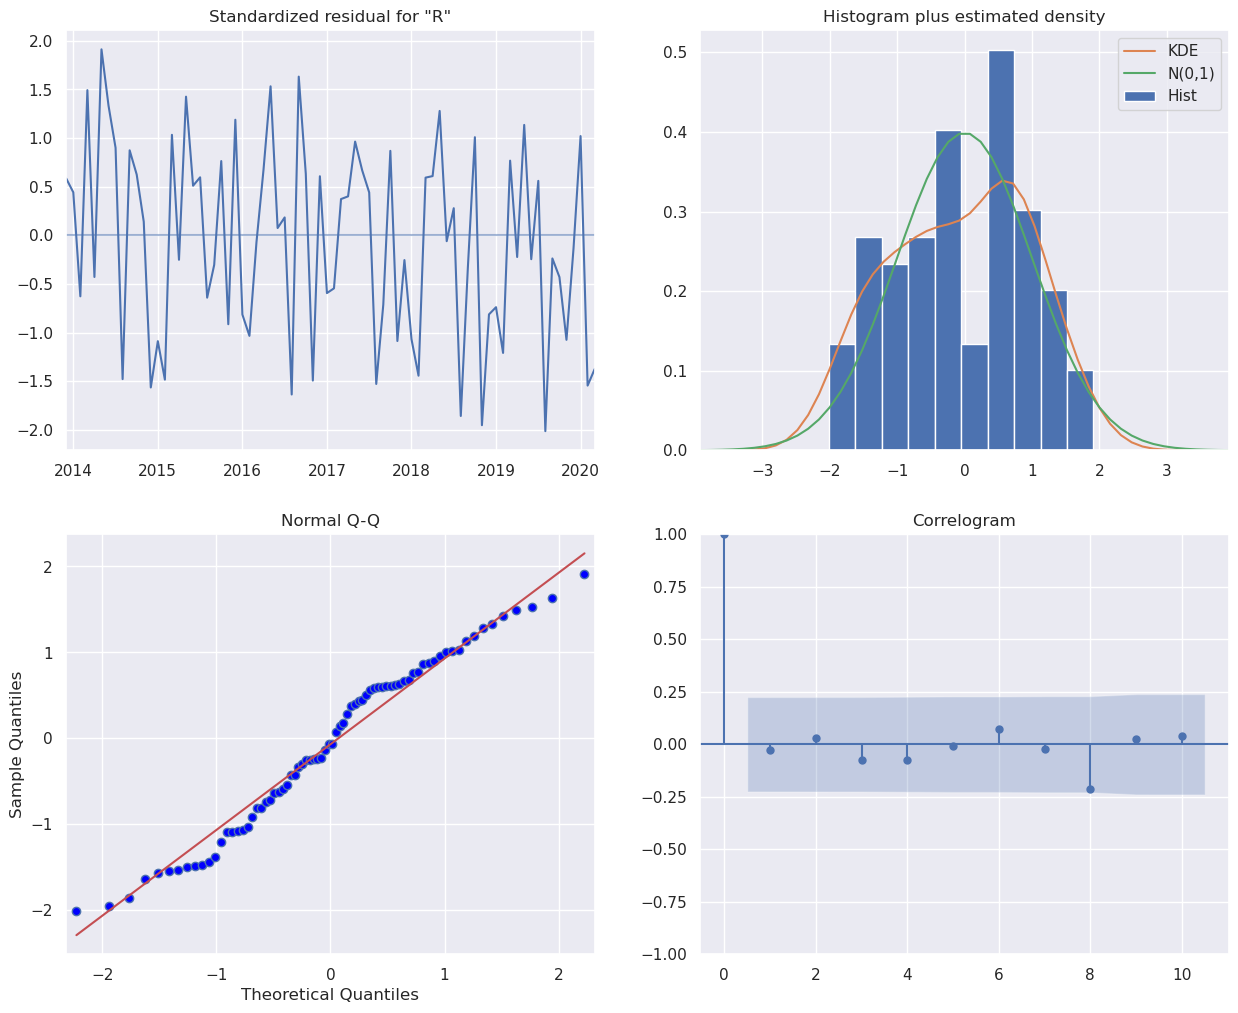

In [53]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [54]:
pred_uc = results.get_forecast(steps=12)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
pred_ci = pred_uc.conf_int()

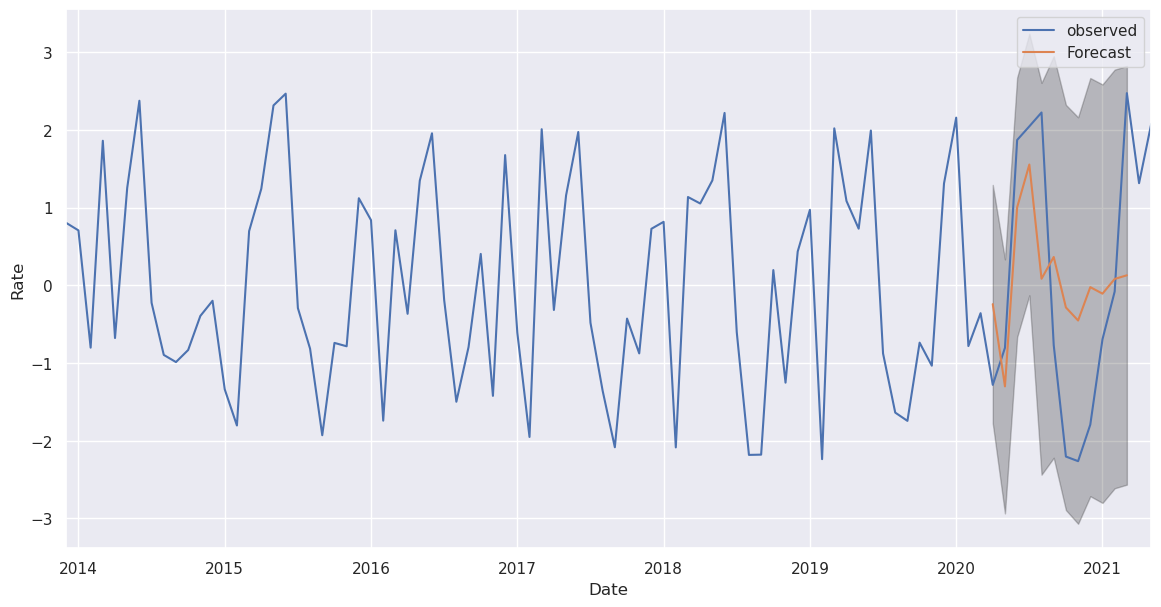

In [55]:
ax = vc_dtrnded.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(vc_dtrnded.name)

plt.legend()
plt.show()

In [56]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')

In [57]:
xf = final_table 

In [58]:
xf=xf.merge(test_ds, left_on='Date', right_on='Month', how='inner')
xf

,Date,Predicted_Mean,Lower Bound,Upper Bound,Rate
0,2020-04-01,-0.24150256,-1.77602681,1.29302168,-1.28041020
1,2020-05-01,-1.29989434,-2.93496069,0.33517200,-0.80339530
2,2020-06-01,1.00484201,-0.66553578,2.67521980,1.87147586
3,2020-07-01,1.55561303,-0.12749887,3.23872493,2.04698822
4,2020-08-01,0.08525342,-2.43604257,2.60654942,2.22528437
5,2020-09-01,0.36545392,-2.21921452,2.95012236,-0.76862698
6,2020-10-01,-0.28408687,-2.89158453,2.32341080,-2.20318089
7,2020-11-01,-0.45210759,-3.06791747,2.16370229,-2.26239336
8,2020-12-01,-0.02249382,-2.71345391,2.66846628,-1.79230848
9,2021-01-01,-0.10666638,-2.79985627,2.58652351,-0.69407914


In [59]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [60]:
rmse(xf['Predicted_Mean'], xf['Rate'])

1.4184259012160652

In [61]:
df_crime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls: string (nullable = true)
 |-- Long: double (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA: string (nullable = true)
 |-- LSOA_Name: string (nullable = true)
 |-- Crime_Type: string (nullable = true)
 |-- Last_Outcome: string (nullable = true)
 |-- Context: string (nullable = true)



In [62]:
df_crime = df_crime.withColumn("Region", expr("substring(LSOA_Name, 1, length(LSOA_Name)-5)"))

In [63]:
df_Lei = (df_crime
          .select('Region', 'Month')
          .where((df_crime.Crime_Type == 'Violence and sexual offences') & (df_crime.Region=='Leicester'))
          .groupBy('Region','Month')
          .count()
          .orderBy('Month')
         )

In [64]:
df_Lei = df_Lei.select('Month', 'count')

In [65]:
lei_pd = df_Lei.toPandas()

In [66]:
df_Lei=df_crime=[]

In [67]:
lei_pd.Month = lei_pd.Month.astype('datetime64[ns]')
lei_pd = lei_pd.set_index(pd.to_datetime(lei_pd.Month))

In [68]:
# create a copy of the dataframe, and add columns for month and year
df_m = lei_pd.copy()
df_m['month'] = [i.month for i in df_m.index]
df_m['year'] = [i.year for i in df_m.index]
# group by month and year, get the average
df_m = df_m.groupby(['month', 'year']).mean().dropna()

In [69]:
df_m = df_m.unstack(level=0)

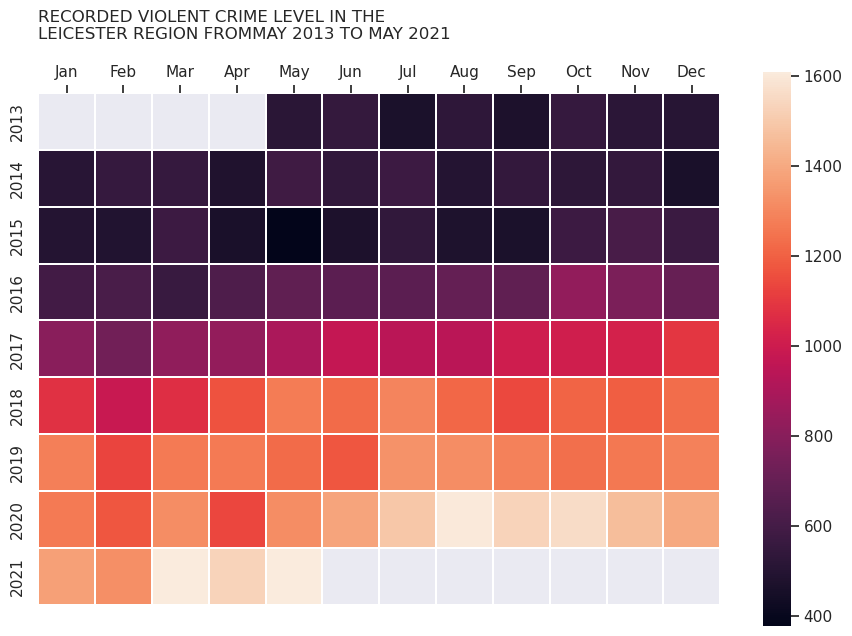

In [70]:
# figure
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(df_m, square=True,
           linewidth=0.3, cbar_kws={"shrink": .8})
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Recorded Violent Crime level in The \nLeicester Region fromMay 2013 to May 2021\n'.upper()
plt.title(title, loc='left')
plt.show()

In [71]:
plt.figsize=(20, 6)

lei_pd.plot(y='count', x='Month',marker='.', linestyle='-', linewidth=1.5,\
         subplots=False,
              label='Violent Crime Rate',
              title='Violent Crime Rate')
plt.ylabel('Violent Crime Frequency In Leicester')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

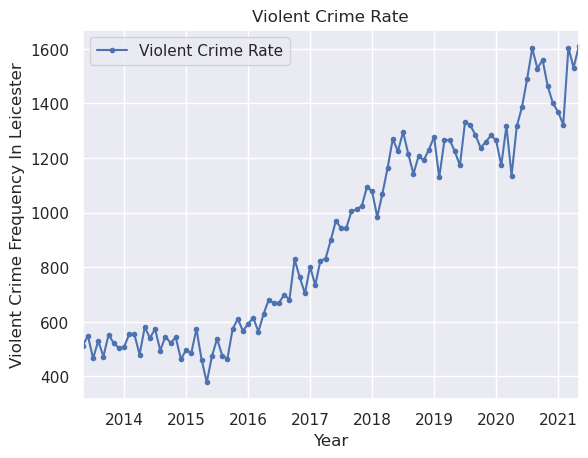

In [72]:
plt.show()

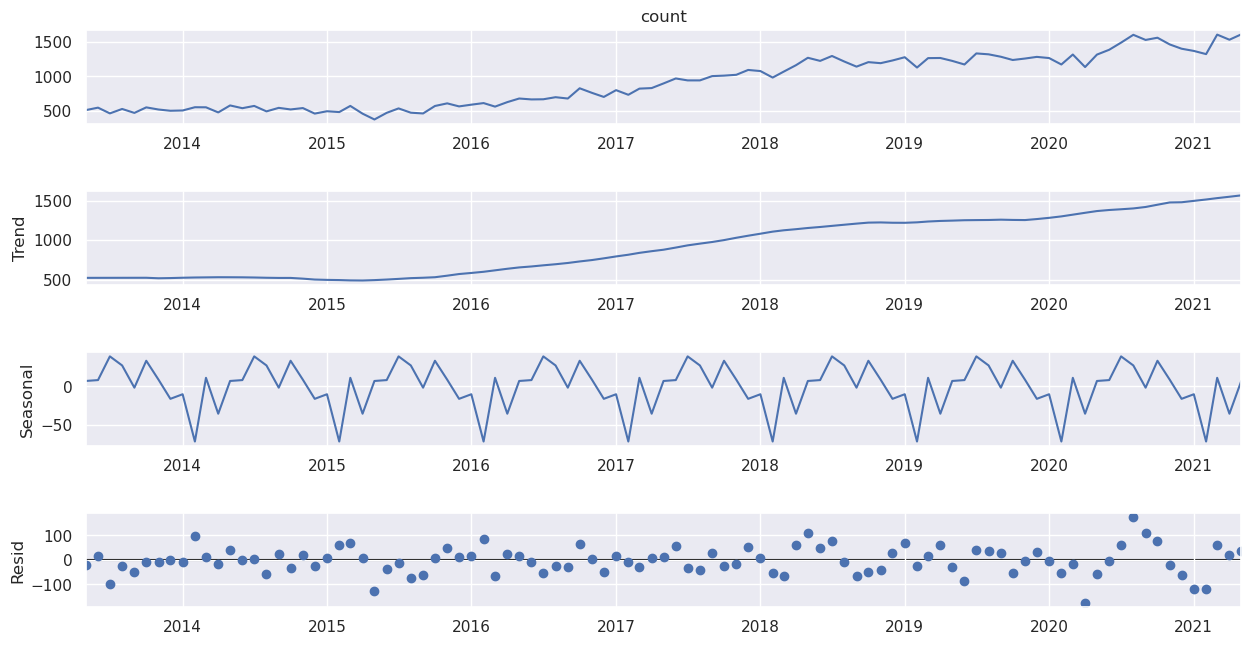

In [73]:
decomposition = sm.tsa.seasonal_decompose(lei_pd['count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [74]:
lei_pd2 = lei_pd[(lei_pd.Month.dt.year > 2016)]

In [75]:
plt.figsize=(20, 6)

lei_pd2.plot(y='count', x='Month',marker='.', linestyle='-', linewidth=1.5,\
         subplots=False,
              label='Violent Crime Rate',
              title='Violent Crime Rate')
plt.ylabel('Violent Crime Frequency')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

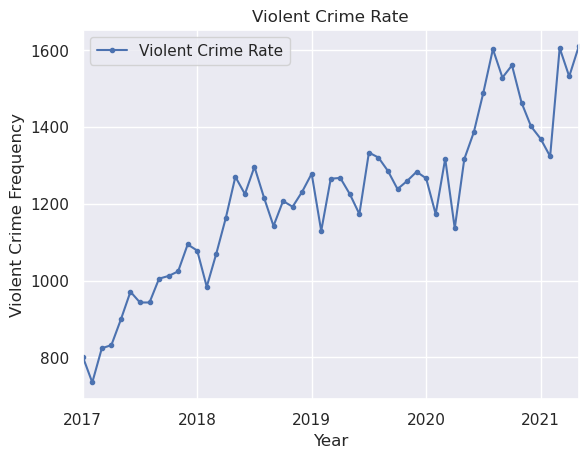

In [76]:
plt.show()

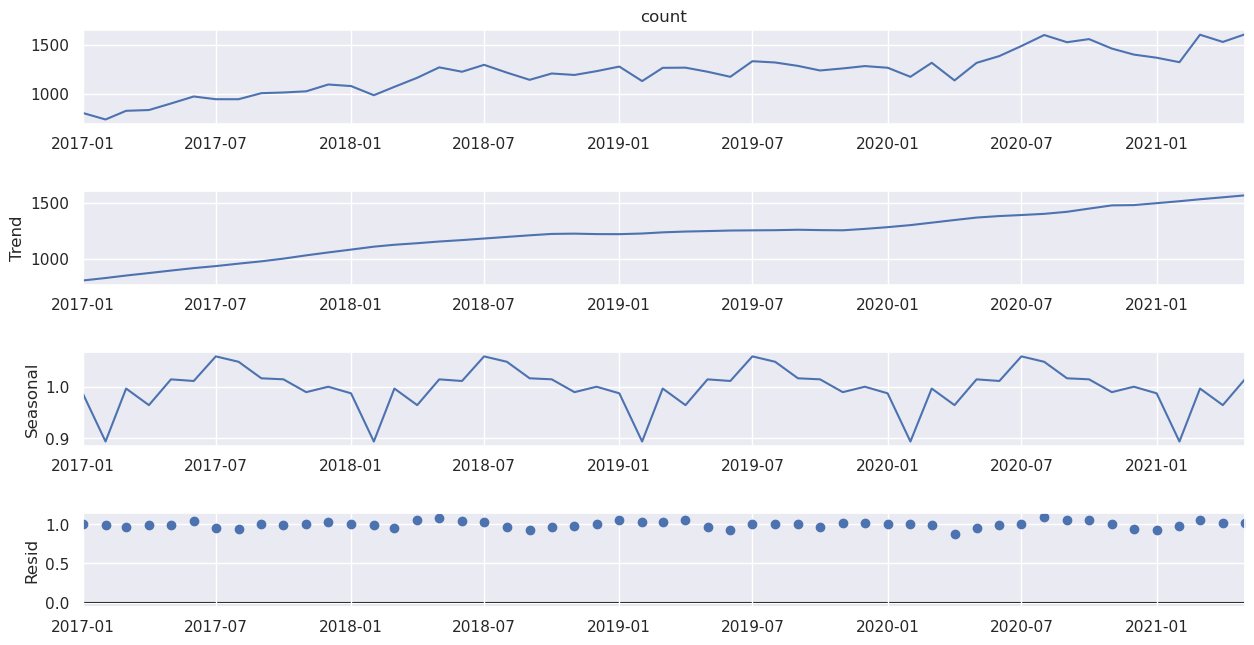

In [77]:
decomposition = sm.tsa.seasonal_decompose(lei_pd2['count'], model='multiplicative',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

<Figure size 640x480 with 0 Axes>

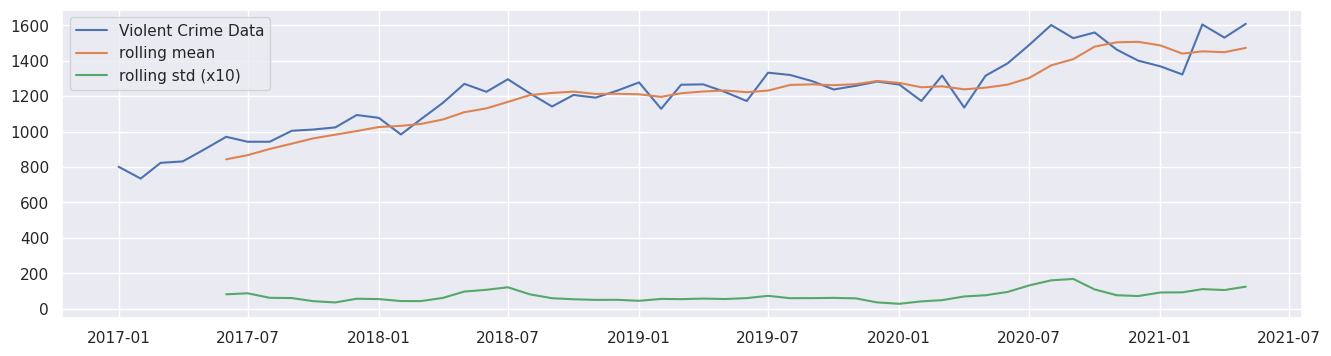

In [78]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(lei_pd2['count'],'Violent Crime Data')

In [79]:
ADF_test(lei_pd2['count'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.572
P-value = 0.497
Critical values :
	1%: -3.5656240522121956 - The data is not stationary with 99% confidence
	5%: -2.920142229157715 - The data is not stationary with 95% confidence
	10%: -2.598014675124952 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

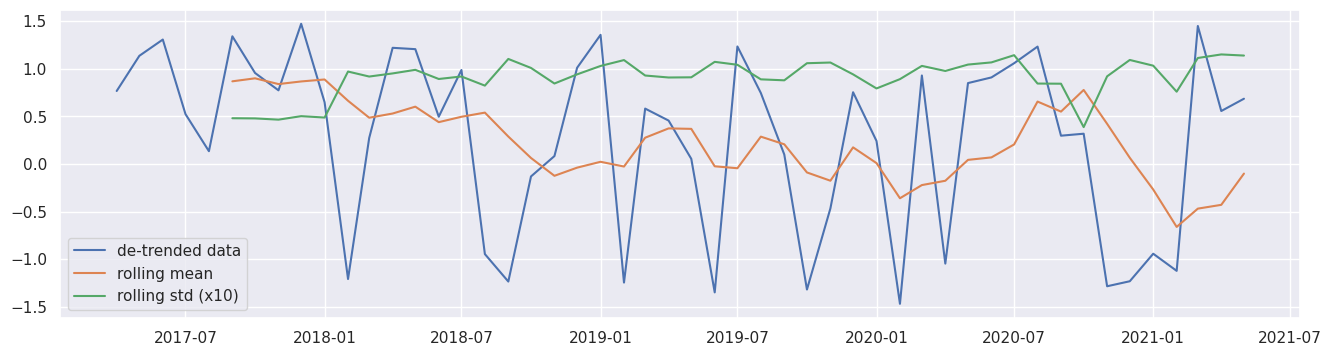

 > Is the de-trended data stationary ?
Test statistic = -5.643
P-value = 0.000
Critical values :
	1%: -3.5714715250448363 - The data is  stationary with 99% confidence
	5%: -2.922629480573571 - The data is  stationary with 95% confidence
	10%: -2.5993358475635153 - The data is  stationary with 90% confidence


In [80]:
# Detrending
pd_lei = lei_pd2['count']
dt_lei =  (pd_lei - pd_lei.rolling(window=4).mean())/pd_lei.rolling(window=4).std()

test_stationarity(dt_lei,'de-trended data')
ADF_test(dt_lei,'de-trended data')

In [81]:
lei_ntrend = dt_lei.dropna()

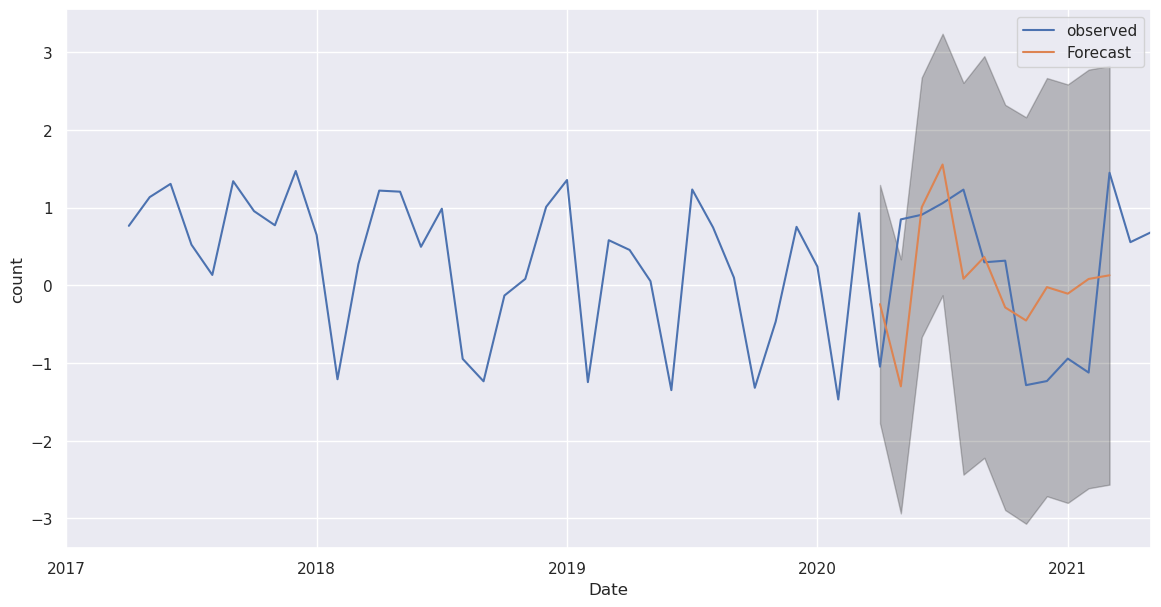

In [82]:
ax = dt_lei.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(dt_lei.name)

plt.legend()
plt.show()

In [83]:
print(dt_lei.loc['2020-04':])

Month
2020-04-01   -1.04599347
2020-05-01    0.84966239
2020-06-01    0.90909358
2020-07-01    1.05828289
2020-08-01    1.23276779
2020-09-01    0.29722987
2020-10-01    0.31801329
2020-11-01   -1.28395086
2020-12-01   -1.23126906
2021-01-01   -0.94232345
2021-02-01   -1.12224992
2021-03-01    1.44957710
2021-04-01    0.55632284
2021-05-01    0.68547368
Name: count, dtype: float64


In [84]:
end_time = dt.now() 
time_elapsed = end_time - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:21:16.781763
